In [30]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/felipe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython import display
import time

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

In [33]:
spark = SparkSession.builder\
    .master('local[4]')\
    .appName('twitter_wordcloud')\
    .getOrCreate()

In [34]:
def trata_tweets(tweets: DataFrame):
    words = tweets\
        .select(
            F.explode(
                F.split(F.lower('_c0'), ' ')
            ).alias('word')
        )\
        .withColumn('word', F.regexp_replace('word', r'http\S+', ''))\
        .withColumn('word', F.regexp_replace('word', r'@\w+', ''))\
        .withColumn('word', F.regexp_replace('word', r'rt', ''))\
        .na.replace('', None)\
        .na.drop()
    return words
    

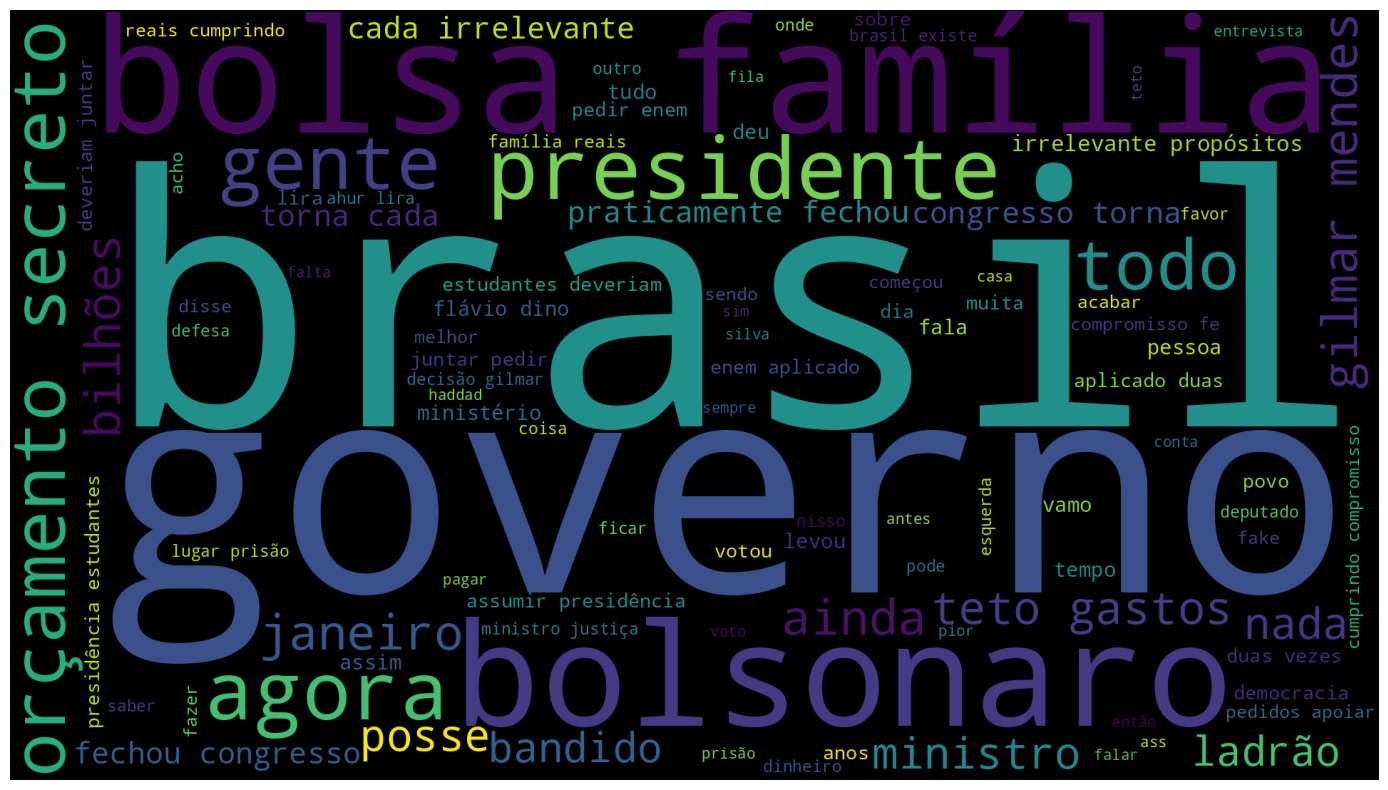

In [36]:
stops = stopwords.words('portuguese')
stops.append('lula')
plt.figure(figsize=(20, 10))

while True:
    try:
        tweets = spark.read.csv('./datalake/csv', encoding='utf-8')
        words = trata_tweets(tweets)
        rows = words.collect()
        all_words = ''
        for row in rows:
            all_words += (' ' + row['word'])
        
        wordcloud = WordCloud(
            stopwords=stops,
            background_color='black',
            width=1920,
            height=1080,
            max_words=100
        ).generate(all_words)
        plt.cla()
        plt.axis('off')
        plt.imshow(wordcloud)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(5)
    except KeyboardInterrupt:
        break